### Importing all the important libraries

In [11]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import random as rd
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Data Understanding

In [12]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Dataset Creation

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed = 123,
                                                              validation_split = 0.2,
                                                              subset = 'training',
                                                              image_size = (img_height,img_width),
                                                              batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed = 123,
                                                              validation_split = 0.2,
                                                              subset = 'validation',
                                                              image_size = (img_height,img_width),
                                                              batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
# Listing out all the classes of skin cancer and storing them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization

In [18]:
# Creating a function to select one image from each class randomly.
def get_sample_img(data_path, labels):
    sample_img =[]                                                       # Initializing the empty array
    for label in labels:
        val = label                                                         # Using the class name
        val_cnt = len(list(data_path.glob('{}/*.jpg'.format(val))))         # Number of images of a particular class
        rn = rd.randrange(0, val_cnt)                                       # assigning a random number for eah class
        img = mpimg.imread(list(data_path.glob('{}/*.jpg'.format(val)))[rn])# Reading the image
        sample_img.append(img)                                           # Adding the image data 
    return sample_img

In [19]:
# Getting the samples from the training dataset
samples = get_sample_img(data_dir_train,class_names)

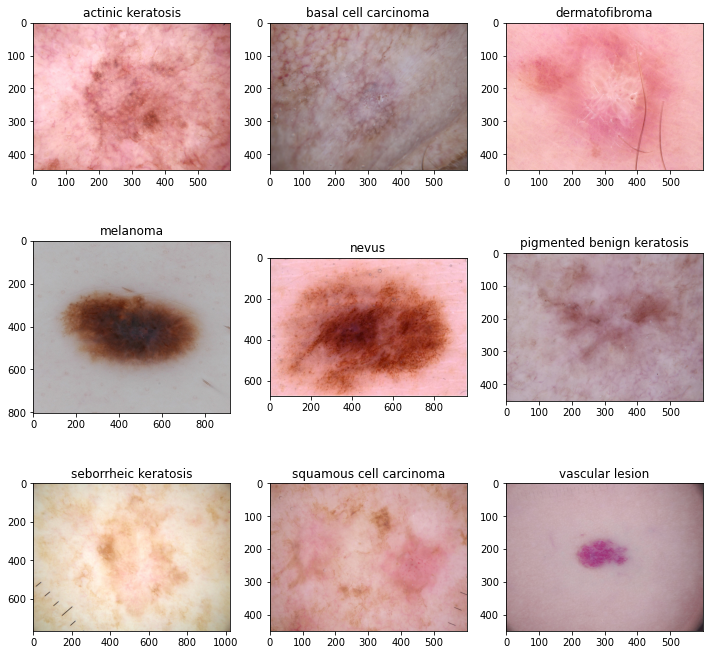

In [22]:
# Visualizing all the 9 classes in one plot

fig = plt.figure(figsize=(12,12))

for idx_img in range(9):
    ax = fig.add_subplot(3, 3, idx_img+1)
    plt.title(class_names[idx_img])
    img = samples[idx_img]
    ax.imshow(img)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
# The input size for each batch in train_ds
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


## Creating Model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Model 1: Without dropout layer

In [25]:
num_classes = 9

model_1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling Model
Choosing an appropirate optimiser and loss function for model training 

In [26]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

### Training Model

In [28]:
# Training the model for 20 epochs
epochs=20
Train_model_1 = model_1.fit(
  train_ds,
  validation_data=val_ds, 
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 82s 1s/step - loss: 1.8424 - accuracy: 0.3237 - val_loss: 1.6229 - val_accuracy: 0.4362
Epoch 2/20
56/56 [==============================] - 66s 1s/step - loss: 1.5342 - accuracy: 0.4632 - val_loss: 1.4970 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 66s 1s/step - loss: 1.3615 - accuracy: 0.5246 - val_loss: 1.5433 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 66s 1s/step - loss: 1.2768 - accuracy: 0.5324 - val_loss: 1.3897 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 66s 1s/step - loss: 1.1931 - accuracy: 0.5781 - val_loss: 1.4433 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 66s 1s/step - loss: 1.1438 - accuracy: 0.5887 - val_loss: 1.4813 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 66s 1s/step - loss: 1.0367 - accuracy: 0.6311 - val_loss: 1.3704 - val_accuracy: 0.5056
Epoch 8/20
56/56 [==

### Visualizing training results

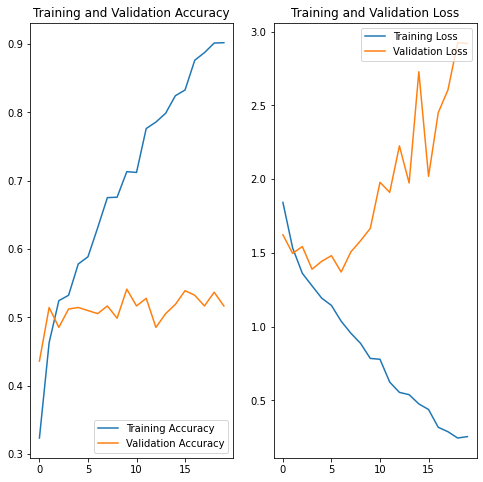

In [29]:
acc = Train_model_1.history['accuracy']
val_acc = Train_model_1.history['val_accuracy']

loss = Train_model_1.history['loss']
val_loss = Train_model_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Overfitting

The difference between the the Training accuracy and validation accuracy is almost 40 % at 20 epochs and the validation accuracy does'nt improve much after 8th epoch and the loss for validation data rises with epochs. This implies that the model is overfitting the training data. When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

### Data Augmentation
Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [30]:
# Augmenting using the sequetial API in tensorflow.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

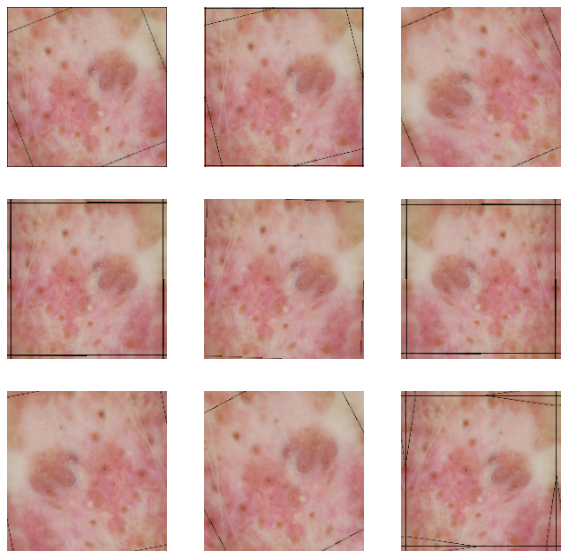

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model 2: With dropout layer

In [32]:
# model_2, using the augmented data to increase the traindataset and using dropout layers for optimal model execution.

model_2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])


### Compiling Model

In [33]:
# Compiling the model_2 and looking at its summary
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)       

### Training Model

In [34]:
# Training the second model which uses augmented data and dropout layers
epochs = 20
Train_model_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 74s 1s/step - loss: 2.2721 - accuracy: 0.1758 - val_loss: 2.0213 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 62s 1s/step - loss: 1.9476 - accuracy: 0.2757 - val_loss: 1.9504 - val_accuracy: 0.2729
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 1.7308 - accuracy: 0.3767 - val_loss: 1.6232 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 69s 1s/step - loss: 1.6602 - accuracy: 0.4096 - val_loss: 1.6303 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 70s 1s/step - loss: 1.5917 - accuracy: 0.4308 - val_loss: 1.5250 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 69s 1s/step - loss: 1.5363 - accuracy: 0.4487 - val_loss: 1.5043 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 69s 1s/step - loss: 1.5426 - accuracy: 0.4526 - val_loss: 1.4924 - val_accuracy: 0.4877
Epoch 8/20
56/56 [==

### Visualizing the results

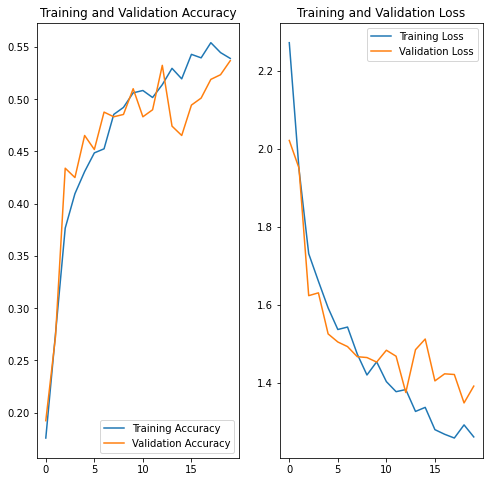

In [35]:
acc = Train_model_2.history['accuracy']
val_acc = Train_model_2.history['val_accuracy']

loss = Train_model_2.history['loss']
val_loss = Train_model_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
After using the dropout layers with data augmentation, the loss is considerably lower, but the accuracy is still low which is probably linked to the class imbalance present in the dataset.

### Class Distribution
Checking the class imbalance in train and test dataset

In [36]:
# Creating a dictionary for the class labels
label_class = {0: 'actinic keratosis', 1: 'basal cell carcinoma',2: 'dermatofibroma',
         3: 'melanoma',4: 'nevus',5: 'pigmented benign keratosis',6: 'seborrheic keratosis',
         7: 'squamous cell carcinoma',8: 'vascular lesion'}

def get_class_dis(data_path,label_class):
    df = pd.DataFrame()
    df['Class_Label'] = label_class.values()
    df['Class_Label_count'] = df['Class_Label'].apply(lambda v: len(list(data_path.glob('{}/*.jpg'.format(v)))))
    df['Class_label_percentage'] = df['Class_Label_count'].apply(lambda v: 
                                                                 round((v/df['Class_Label_count'].sum())*100, 2) )
    return df

In [39]:
# Class label distribution for training dataset of the original data
get_class_dis(data_dir_train,label_class)

,Class_Label,Class_Label_count,Class_label_percentage
0,actinic keratosis,114,5.09
1,basal cell carcinoma,376,16.79
2,dermatofibroma,95,4.24
3,melanoma,438,19.56
4,nevus,357,15.94
5,pigmented benign keratosis,462,20.63
6,seborrheic keratosis,77,3.44
7,squamous cell carcinoma,181,8.08
8,vascular lesion,139,6.21


In [40]:
# Class label distribution for test dataset of the original data
get_class_dis(data_dir_test,label_class)

,Class_Label,Class_Label_count,Class_label_percentage
0,actinic keratosis,16,13.56
1,basal cell carcinoma,16,13.56
2,dermatofibroma,16,13.56
3,melanoma,16,13.56
4,nevus,16,13.56
5,pigmented benign keratosis,16,13.56
6,seborrheic keratosis,3,2.54
7,squamous cell carcinoma,16,13.56
8,vascular lesion,3,2.54


#### Observations on the class labels:
The training dataset has many classes where the number of labels is very low in comparision to others, eg. dermatofibroma and  seborrheic keratosis make up less than 5 % of the training dataset. Hence use of augmentation is required for improving the model performance.

In [41]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


## Handling class imbalances using augmenter

In [45]:
path_to_training_dataset=r"C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+"\\"+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC352F3EB0>:   0%|         | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC35765F70>: 100%|█| 500/500 [00:04<00:00, 102.95 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EC35653FD0>: 100%|█| 500/500 [00:05<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC2F52DE50>: 100%|█| 500/500 [00:05<00:00, 92.49 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1EC35653B50>:   0%| | 1/500 [00:00<01:04

Initialised with 438 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EC2F32AEB0>: 100%|█| 500/500 [00:32<00:00, 15.19 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1EC6E67EDF0>: 100%|█| 500/500 [00:30<00:00, 16.33 Sample
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC35243B50>:   2%| | 11/500 [00:00<00:59,  8.27 Samples/s

Initialised with 462 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC7221CC70>: 100%|█| 500/500 [00:08<00:00, 62.49 Samples/
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1EC351B4CA0>: 100%|█| 500/500 [00:16<00
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC2F51AF70>: 100%|█| 500/500 [00:07<00:00, 64.66 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EC6F9FD7C0>:   0%| | 2/500 [00:00<01:28

Initialised with 139 image(s) found.
Output directory set to C:\Users\Sahil Bajaj\Python Notebooks\PGD_ML_AI\cnn\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC26A13FD0>: 100%|█| 500/500 [00:07<00:00, 65.39 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [47]:
from glob import glob

In [48]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_36ba6a6b-e84c-4a69-85b5-a008460f4314.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4f1c93f0-9dca-4ac6-8120-d091e433e9ba.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8233a679-b1a0-4cdf-8670-66587e714a13.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8ade118b-4135-4e44-b985-72f5ae0a1a0e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_85f6b703-1903-4eb5-aef4-8e5b01ded7c6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [50]:
original_df = pd.DataFrame()

In [51]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [53]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
squamous cell carcinoma       500
nevus                         500
actinic keratosis             500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Model 3: With dropout layer using augmenter

In [54]:
batch_size = 32
img_height = 180
img_width = 180

In [55]:
train_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [56]:
val_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_aug = train_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_aug = val_aug.cache().prefetch(buffer_size=AUTOTUNE)

### Creating Model

In [60]:
num_classes = 9
model_3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

### Compiling Model

In [61]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training Model

In [63]:
# Training the model for 20 epochs
epochs=20
Train_model_3 = model_3.fit(
  train_aug,
  validation_data=val_aug, 
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 332s 2s/step - loss: 4.4931 - accuracy: 0.1882 - val_loss: 23.6781 - val_accuracy: 0.1039
Epoch 2/20
169/169 [==============================] - 290s 2s/step - loss: 2.0265 - accuracy: 0.2127 - val_loss: 10.1712 - val_accuracy: 0.1039
Epoch 3/20
169/169 [==============================] - 318s 2s/step - loss: 2.0038 - accuracy: 0.2042 - val_loss: 11.6800 - val_accuracy: 0.1076
Epoch 4/20
169/169 [==============================] - 285s 2s/step - loss: 1.9995 - accuracy: 0.2046 - val_loss: 2.3101 - val_accuracy: 0.1752
Epoch 5/20
169/169 [==============================] - 286s 2s/step - loss: 1.9871 - accuracy: 0.2046 - val_loss: 2.2910 - val_accuracy: 0.1633
Epoch 6/20
169/169 [==============================] - 285s 2s/step - loss: 1.9523 - accuracy: 0.2159 - val_loss: 1.8284 - val_accuracy: 0.2754
Epoch 7/20
169/169 [==============================] - 285s 2s/step - loss: 1.9482 - accuracy: 0.2122 - val_loss: 2.1033 - val_accuracy: 0.2

In [64]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)       

### Visualizing the results

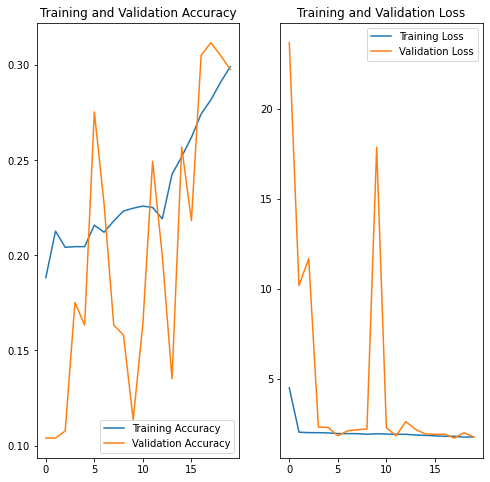

In [65]:
acc = Train_model_3.history['accuracy']
val_acc = Train_model_3.history['val_accuracy']

loss = Train_model_3.history['loss']
val_loss = Train_model_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclussions:
The model performed better comparision without use of augmenter and batch normalization, the validation loss is also to high in the begining and overall accuracy of the model is poor for training and validation. The reason for this maybe because the second method of augmentation created duplicate data twice the size of the dataset.